In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import classyNN as cnn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

## Input

In [3]:
hlayers_sizes   = (300,100,200)
seed            = 1
verbose_train   = True
epochs          = 20
batch_size      = 128
std_scaler      = True
quantile_scaler = False
out_intervals   = [[1,120], [0.8, 82], [-1, 1], [-1,1], [0.85, 75], [1, 100], [1.45,9], [0.05, 0.5]] 
out_intervals   = np.array(out_intervals) # for the LSO, 1.45 corresponds to a=0.99 in Kerr

In [4]:
"""
results for 
hlayers_sizes = (400,400)
seed          = 1
verbose_train = True
epochs        = 10
batch_size    = 128

--------------------------------------------------
x-scaler : Linear Map [-1,1]
y-scaler : Linear Map [-1,1]
--------------------------------------------------
Final R2 mean  : 0.76481
R2[ 0]         : 0.87767
R2[ 1]         : 0.92990
R2[ 2]         : 0.73263
R2[ 3]         : 0.13910
R2[ 4]         : 0.96615
R2[ 5]         : 0.79244
R2[ 6]         : 0.75168
R2[ 7]         : 0.92887

--------------------------------------------------
x-scaler : Standard scaler (zero-mean / 5 sigma)
y-scaler : Linear Map [-1,1]
--------------------------------------------------
Final R2 mean  : 0.76992
R2[ 0]         : 0.88255
R2[ 1]         : 0.93053
R2[ 2]         : 0.74018
R2[ 3]         : 0.14052
R2[ 4]         : 0.96750
R2[ 5]         : 0.80700
R2[ 6]         : 0.75827
R2[ 7]         : 0.93279

--------------------------------------------------
x-scaler : Standard scaler (zero-mean / 10 sigma)
y-scaler : Linear Map [-1,1]
--------------------------------------------------
Final R2 mean  : 0.76803
R2[ 0]         : 0.88254
R2[ 1]         : 0.93011
R2[ 2]         : 0.73516
R2[ 3]         : 0.13902
R2[ 4]         : 0.96679
R2[ 5]         : 0.80389
R2[ 6]         : 0.75452
R2[ 7]         : 0.93224

--------------------------------------------------
x-scaler : Quantile + Linear Map [-1,1]
y-scaler : QUantile + Linear Map [-1,1]
--------------------------------------------------
Final R2 mean  : 0.47755
R2[ 0]         : 0.54721
R2[ 1]         : 0.63112
R2[ 2]         : 0.50758
R2[ 3]         : -0.08481
R2[ 4]         : 0.72334
R2[ 5]         : 0.37451
R2[ 6]         : 0.52527
R2[ 7]         : 0.59619

""";

## Start by loading the data. This should be exported in py-module

In [5]:
fname_train_data = 'GstLAL/train_NS.csv'
fname_test_data  = 'GstLAL/test_NS.csv'
train_datasets   = cnn.extract_data(fname_train_data, skip_header=True)
test_datasets    = cnn.extract_data(fname_test_data, skip_header=True)

In [6]:
# ID                0
# m1_inj            1
# m2_inj            2
# chi1_inj          3
# chi2_inj          4
# mc_inj            5
# q_inj             6
# R_isco_inj        7
# Compactness_inj   8
# m1_rec            9
# m2_rec           10
# chi1_rec         11
# chi2_rec         12
# mc_rec           13
# frac_mc_err      14
# q_rec            15
# R_isco_rec       16
# Compactness_rec  17
# snr              18
# s                19

def load_GstLAL_data(X, features='mass&spin'):
    """ Maybe a little bit pedantic, 
    but I prefer to keep this function as
    readable as possible 
    """
    if features=='all':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        Compactness_inj = X[:, 8]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        Compactness_rec = X[:,17]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj,Compactness_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec,Compactness_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$', r'$C$']
        
    elif features=='no_compactness':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$']
        
    elif features=='mass&spin':
        m1_inj          = X[:, 1]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        m1_rec          = X[:, 9]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        inj = np.column_stack((m1_inj,chi1_inj,chi2_inj,mc_inj))
        rec = np.column_stack((m1_rec,chi1_rec,chi2_rec,mc_rec))
        names = [r'$m_1$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$']
        
    elif features=='spin':
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        inj = np.column_stack((chi1_inj,chi2_inj))
        rec = np.column_stack((chi1_rec,chi2_rec))
        names = [r'$\chi_1$', r'$\chi_2$']
    ID  = X[:,0]
    snr = X[:,18]
    
    out          = {}
    out['inj']   = inj
    out['rec']   = rec
    out['SNR']   = snr
    out['names'] = names
    out['ID']    = ID
    return out

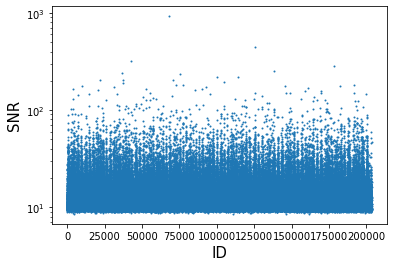

--------------------------------------------------  train  -------------------------------------------------


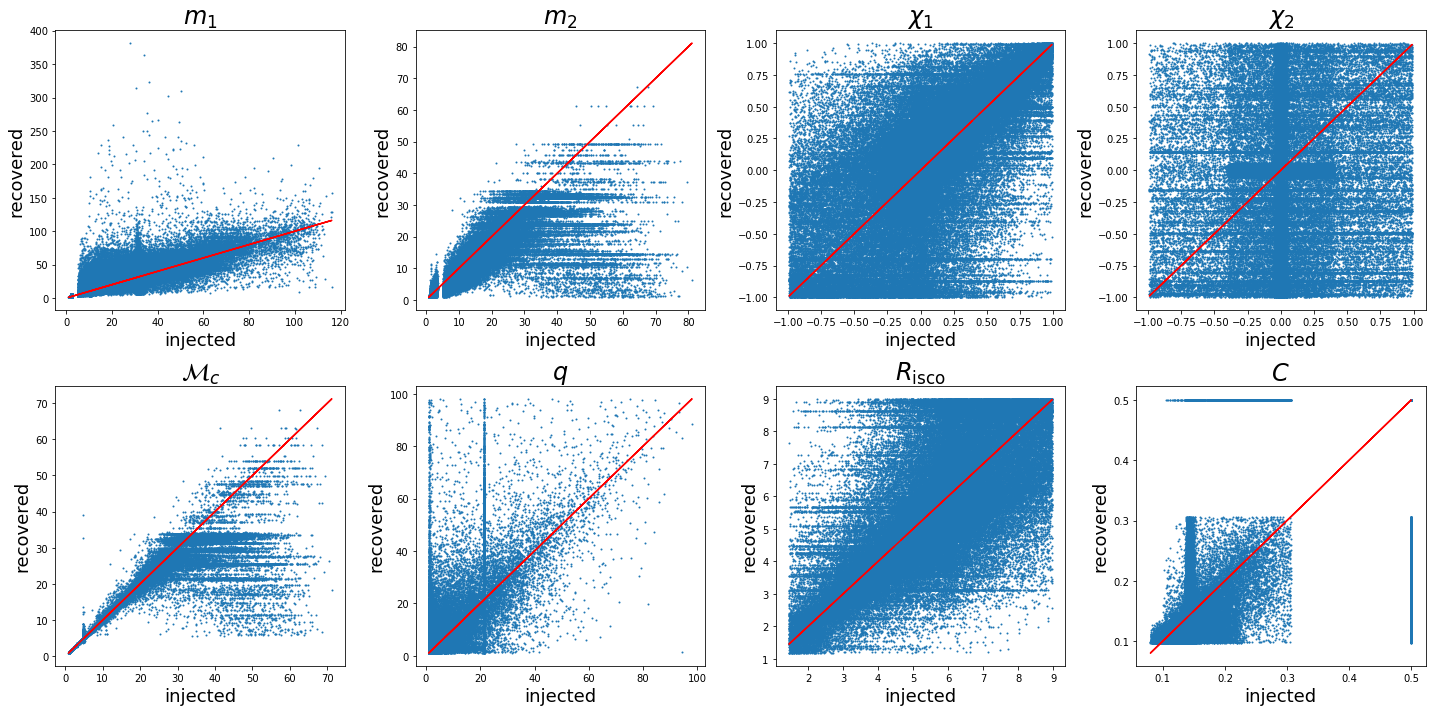

In [7]:
train_data_split = load_GstLAL_data(train_datasets, features='all')
train_inj = train_data_split['inj']
train_rec = train_data_split['rec']
train_snr = train_data_split['SNR']

test_data_split = load_GstLAL_data(test_datasets, features='all')
test_inj = test_data_split['inj']
test_rec = test_data_split['rec']
test_snr = test_data_split['SNR']

names     = train_data_split['names']
nfeatures = len(train_inj[0,:])
ntrain    = len(train_inj[:,0])
ntest     = len( test_inj[:,0])

plt.figure
plt.scatter(train_data_split['ID'], train_snr, s=1)
plt.yscale('log')
plt.ylabel('SNR', fontsize=15)
plt.xlabel('ID', fontsize=15)
plt.show()

print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,10))
for i in range(nfeatures):
    ax = plt.subplot(241+i)
    ax.scatter(train_inj[:,i], train_rec[:,i],s=1)
    ax.plot(train_inj[:,i], train_inj[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
plt.show()


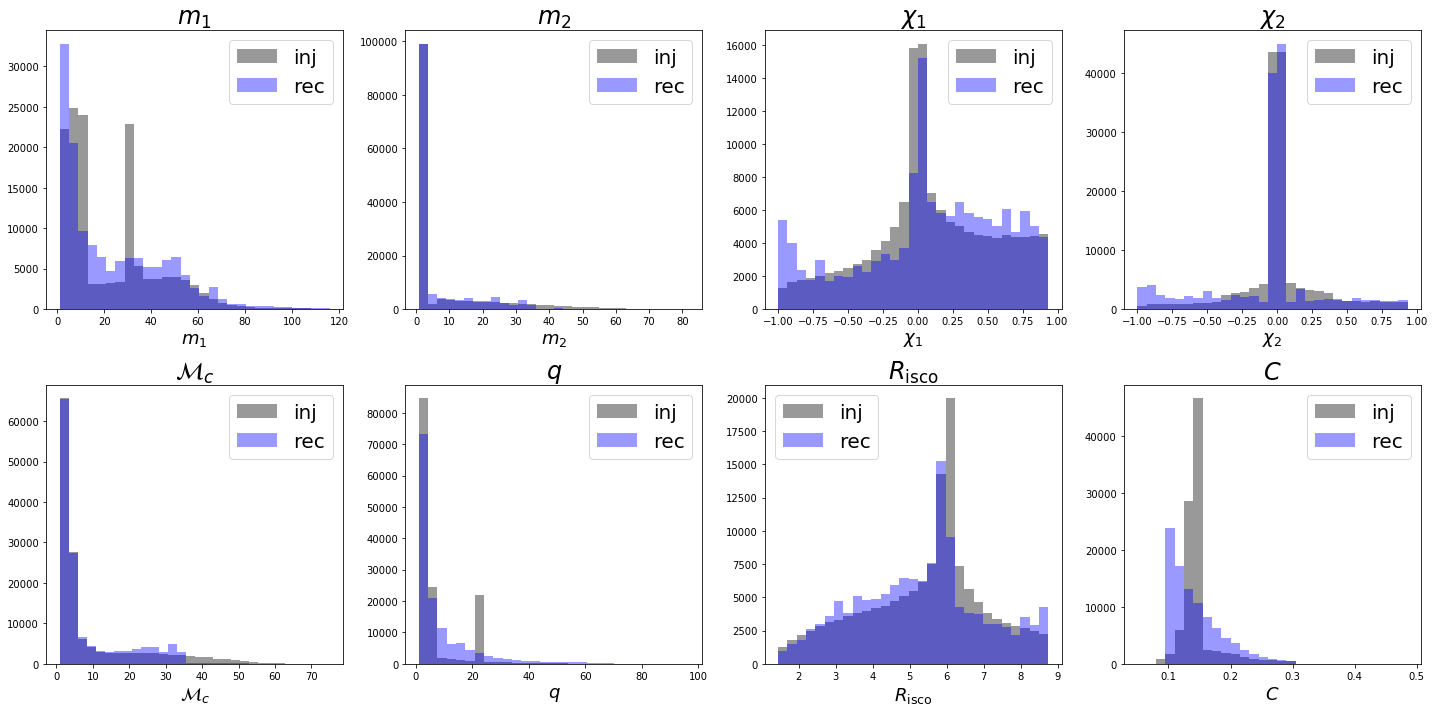

In [8]:
plt.figure(figsize=(20,10))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(241+i)
    fmin  = out_intervals[i][0]
    fmax  = out_intervals[i][1]
    fstep = (fmax-fmin)/nbins
    ax.hist(train_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[0.6,0.6,0.6], label='inj')
    ax.hist(train_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.4, color=[0,0,1], label='rec')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [9]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes, out_intervals=out_intervals, seed=seed)
NN.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 300)               2700      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 200)               20200     
                                                                 
 dense_3 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 54,608
Trainable params: 54,608
Non-trainable params: 0
_________________________________________________________________


In [10]:
NN.load_train_dataset(xtrain_data=train_rec, ytrain_data=train_inj, 
                      verbose=False, quantile=quantile_scaler, standard_scaler=std_scaler)

--------------------------------------------------------------------------------
feature n.0
--------------------------------------------------------------------------------


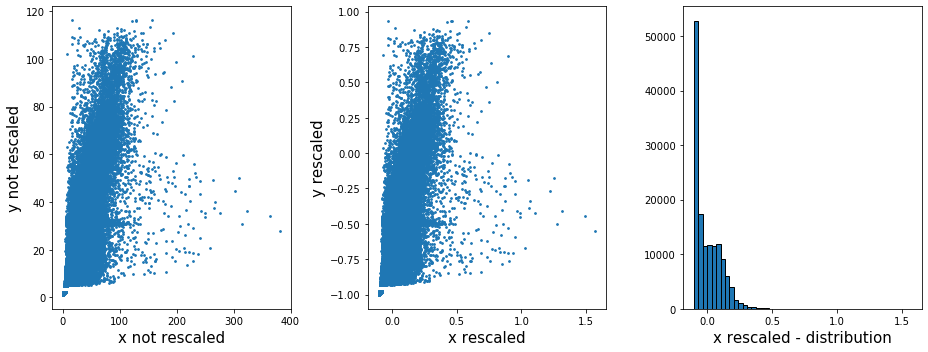

max diff check :  2.842170943040401e-14
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.1
--------------------------------------------------------------------------------


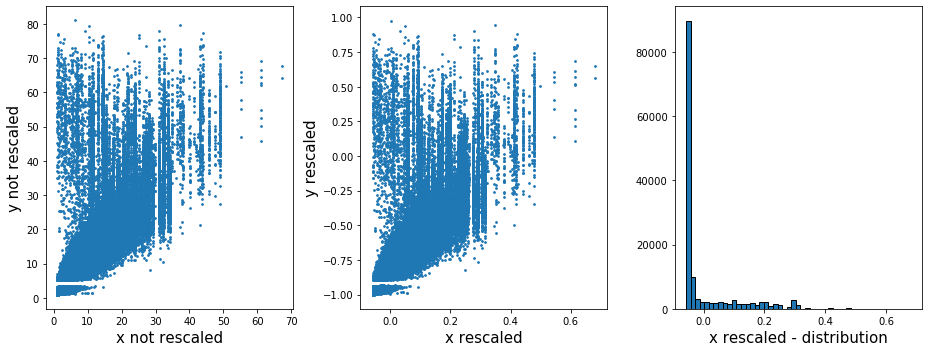

max diff check :  7.105427357601002e-15
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.2
--------------------------------------------------------------------------------


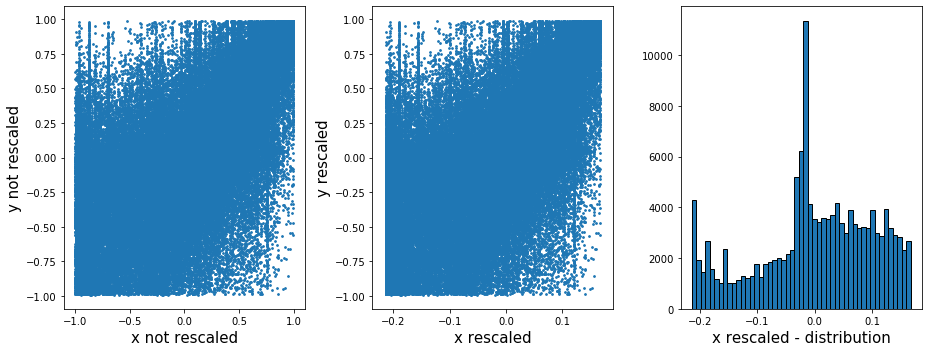

max diff check :  2.220446049250313e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.3
--------------------------------------------------------------------------------


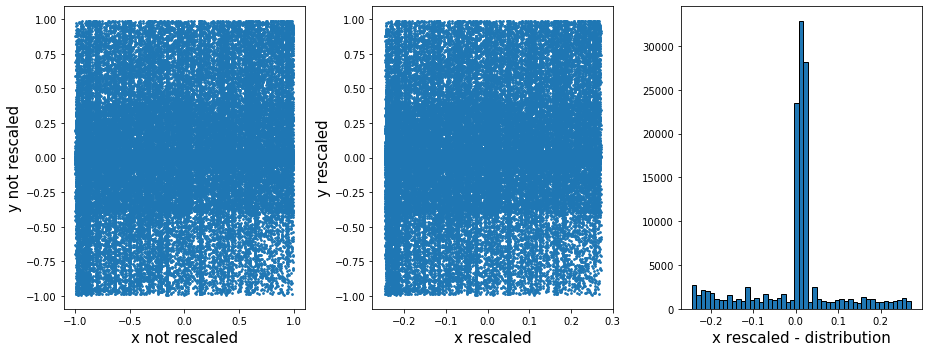

max diff check :  3.3306690738754696e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.4
--------------------------------------------------------------------------------


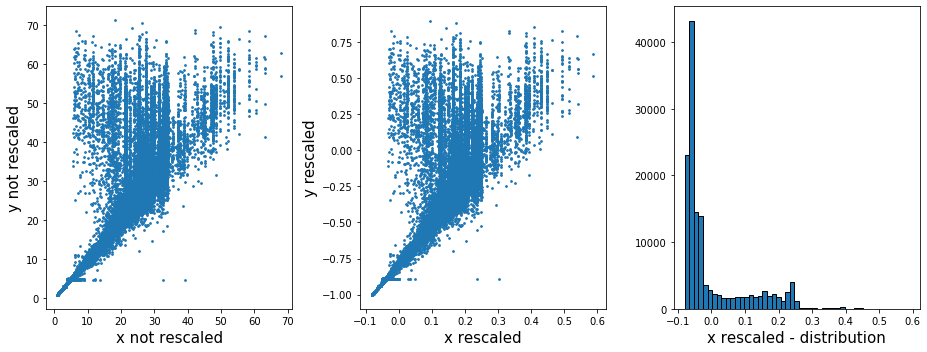

max diff check :  7.105427357601002e-15
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.5
--------------------------------------------------------------------------------


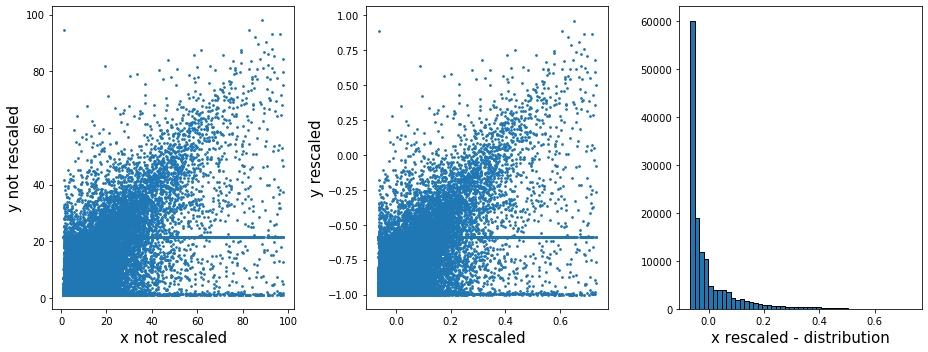

max diff check :  1.4210854715202004e-14
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.6
--------------------------------------------------------------------------------


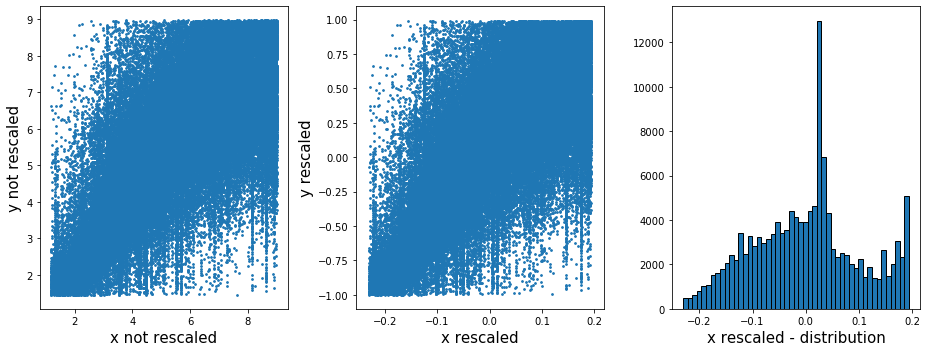

max diff check :  8.881784197001252e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.7
--------------------------------------------------------------------------------


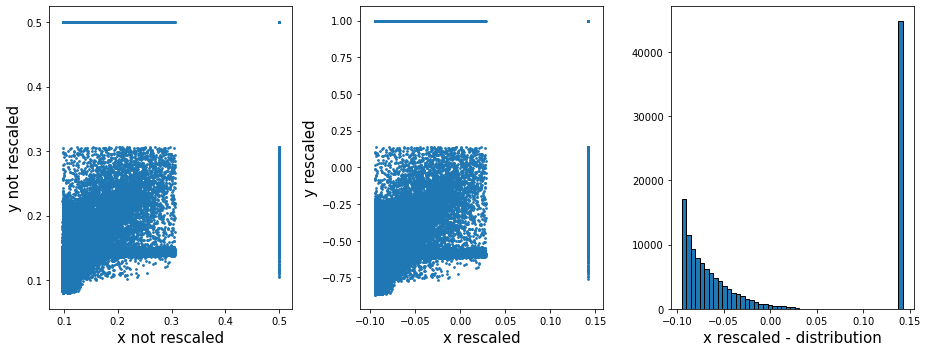

max diff check :  4.163336342344337e-17
NaN found in Y :  0
NaN found in X1:  0 





In [11]:
X0 = NN.xtrain_notnorm
Y  = NN.scaler_x.transform(X0)
X1 = NN.scaler_x.inverse_transform(Y)

for i in range(NN.nfeatures):
    print('-'*80, 'feature n.'+str(i), '-'*80, sep='\n')
    plt.figure(figsize=(13,5))
    plt.subplot(131)
    plt.scatter(NN.xtrain_notnorm[:,i], NN.ytrain_notnorm[:,i], s=3)
    plt.xlabel('x not rescaled', fontsize=15)
    plt.ylabel('y not rescaled', fontsize=15)
    plt.subplot(132)
    plt.scatter(NN.xtrain[:,i], NN.ytrain[:,i], s=3)
    plt.xlabel('x rescaled', fontsize=15)
    plt.ylabel('y rescaled', fontsize=15)
    nan_counter_Y  = 0
    nan_counter_X1 = 0
    for j in range(len(Y[:,i])):
        y  =  Y[j,i]
        x1 = X1[j,i]
        if np.isnan(y):
            nan_counter_Y += 1
        if np.isnan(x1):
            nan_counter_X1 += 1
    if nan_counter_Y == 0:
        plt.subplot(133)
        x = NN.xtrain[:,i]
        plt.hist(x, bins=np.linspace(min(x), max(x), 50), histtype='bar', ec='black')
        #plt.hist(Y[:,i], bins=np.linspace(min(x), max(x), 50), alpha=0.5, histtype='bar', ec='black')
        plt.xlabel('x rescaled - distribution', fontsize=15)
    plt.tight_layout()
    plt.show()
    diff = X1[:,i]-X0[:,i]
    print('max diff check : ', max(diff))
    print('NaN found in Y : ', nan_counter_Y)
    print('NaN found in X1: ', nan_counter_X1, '\n\n\n')

In [12]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train)

Epoch 1/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - R2metric: 0.8560
Epoch 2/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - R2metric: 0.9031
Epoch 3/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - R2metric: 0.9058
Epoch 4/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - R2metric: 0.9068
Epoch 5/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - R2metric: 0.9079
Epoch 6/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - R2metric: 0.9088
Epoch 7/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - R2metric: 0.9093
Epoch 8/20
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0308 

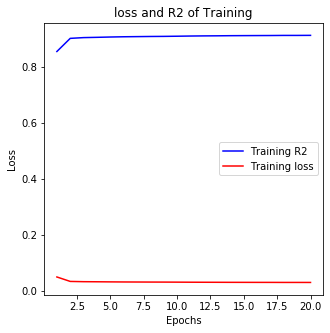

In [13]:
NN.plot_history()

In [14]:
NN.load_test_dataset(xtest_data=test_rec, ytest_data=test_inj, verbose=True)

In [15]:
print('-'*25, 'R2 for recovery', '-'*25)
def R2_numpy(y_true, y_pred):
            SS_res = np.sum((y_true - y_pred )**2)
            SS_tot = np.sum((y_true - np.mean(y_true))**2)
            return 1-SS_res/SS_tot
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_rec[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))

print('-'*25, 'R2 for prediction', '-'*23)
NN.print_metrics()

------------------------- R2 for recovery -------------------------
R2[ 0]         : 0.61870
R2[ 1]         : 0.66875
R2[ 2]         : 0.28814
R2[ 3]         : -1.56280
R2[ 4]         : 0.84706
R2[ 5]         : 0.03416
R2[ 6]         : 0.38333
R2[ 7]         : 0.81511
------------------------- R2 for prediction -----------------------
Final R2 mean  : 0.77277
R2[ 0]         : 0.88346
R2[ 1]         : 0.92895
R2[ 2]         : 0.74729
R2[ 3]         : 0.14587
R2[ 4]         : 0.96509
R2[ 5]         : 0.81222
R2[ 6]         : 0.76359
R2[ 7]         : 0.93566


## Histograms

-------------------------------------------------- m1 --------------------------------------------------
prediction below fmin=-60.00: 15
recovery   below fmin=-60.00: 219
prediction above fmax= 60.00: 20
recovery   above fmax= 60.00: 22


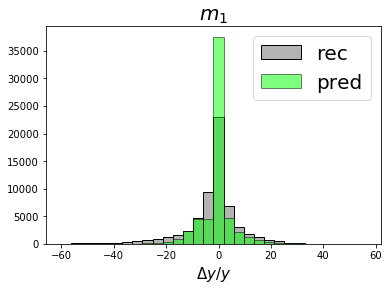

-------------------------------------------------- m2 --------------------------------------------------
prediction below fmin=-20.00: 133
recovery   below fmin=-20.00: 4
prediction above fmax= 20.00: 107
recovery   above fmax= 20.00: 2120


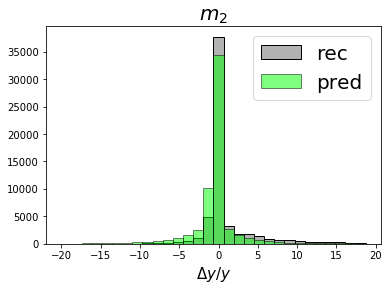

-------------------------------------------------- Chi1 --------------------------------------------------
prediction below fmin= -1.70: 0
recovery   below fmin= -1.70: 5
prediction above fmax=  1.70: 0
recovery   above fmax=  1.70: 28


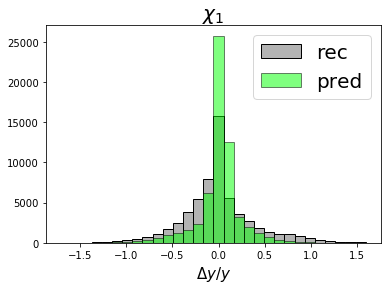

-------------------------------------------------- Chi2 --------------------------------------------------
prediction below fmin= -1.70: 0
recovery   below fmin= -1.70: 43
prediction above fmax=  1.70: 0
recovery   above fmax=  1.70: 162


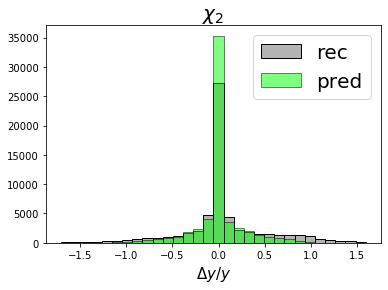

-------------------------------------------------- Mc --------------------------------------------------
prediction below fmin= -3.00: 3325
recovery   below fmin= -3.00: 425
prediction above fmax=  3.00: 1706
recovery   above fmax=  3.00: 5321


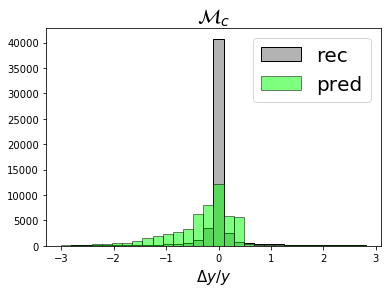

-------------------------------------------------- q --------------------------------------------------
prediction below fmin=-20.00: 160
recovery   below fmin=-20.00: 2020
prediction above fmax= 20.00: 261
recovery   above fmax= 20.00: 194


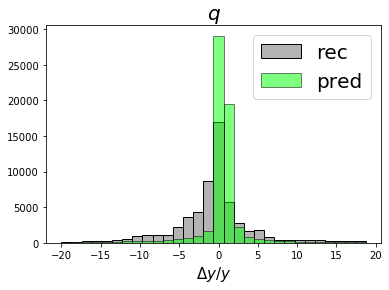

-------------------------------------------------- Risco --------------------------------------------------
prediction below fmin= -6.00: 0
recovery   below fmin= -6.00: 26
prediction above fmax=  6.00: 0
recovery   above fmax=  6.00: 1


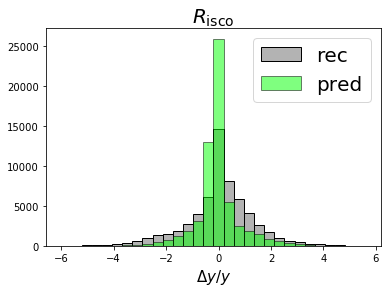

-------------------------------------------------- Comp --------------------------------------------------
prediction below fmin= -0.37: 1
recovery   below fmin= -0.37: 10
prediction above fmax=  0.37: 0
recovery   above fmax=  0.37: 86


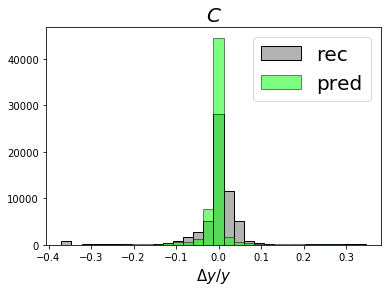

In [16]:
print('-'*50, 'm1', '-'*50)
NN.plot_err_histogram(feature_idx=0, fmin=-60, fmax=60, verbose=True, name=names[0])

print('-'*50, 'm2', '-'*50)
NN.plot_err_histogram(feature_idx=1, fmin=-20, fmax=20, verbose=True, name=names[1])

print('-'*50, 'Chi1', '-'*50)
NN.plot_err_histogram(feature_idx=2, fmin=-1.7, fmax=1.7, verbose=True, name=names[2])

print('-'*50, 'Chi2', '-'*50)
NN.plot_err_histogram(feature_idx=3, fmin=-1.7, fmax=1.7, verbose=True, name=names[3])

print('-'*50, 'Mc', '-'*50)
NN.plot_err_histogram(feature_idx=4, fmin=-3, fmax=3, verbose=True, name=names[4])

print('-'*50, 'q', '-'*50)
NN.plot_err_histogram(feature_idx=5, fmin=-20, fmax=20, verbose=True, name=names[5])

print('-'*50, 'Risco', '-'*50)
NN.plot_err_histogram(feature_idx=6, fmin=-6, fmax=6, verbose=True, name=names[6])

print('-'*50, 'Comp', '-'*50)
NN.plot_err_histogram(feature_idx=7, fmin=-0.37, fmax=0.37, verbose=True, name=names[7])

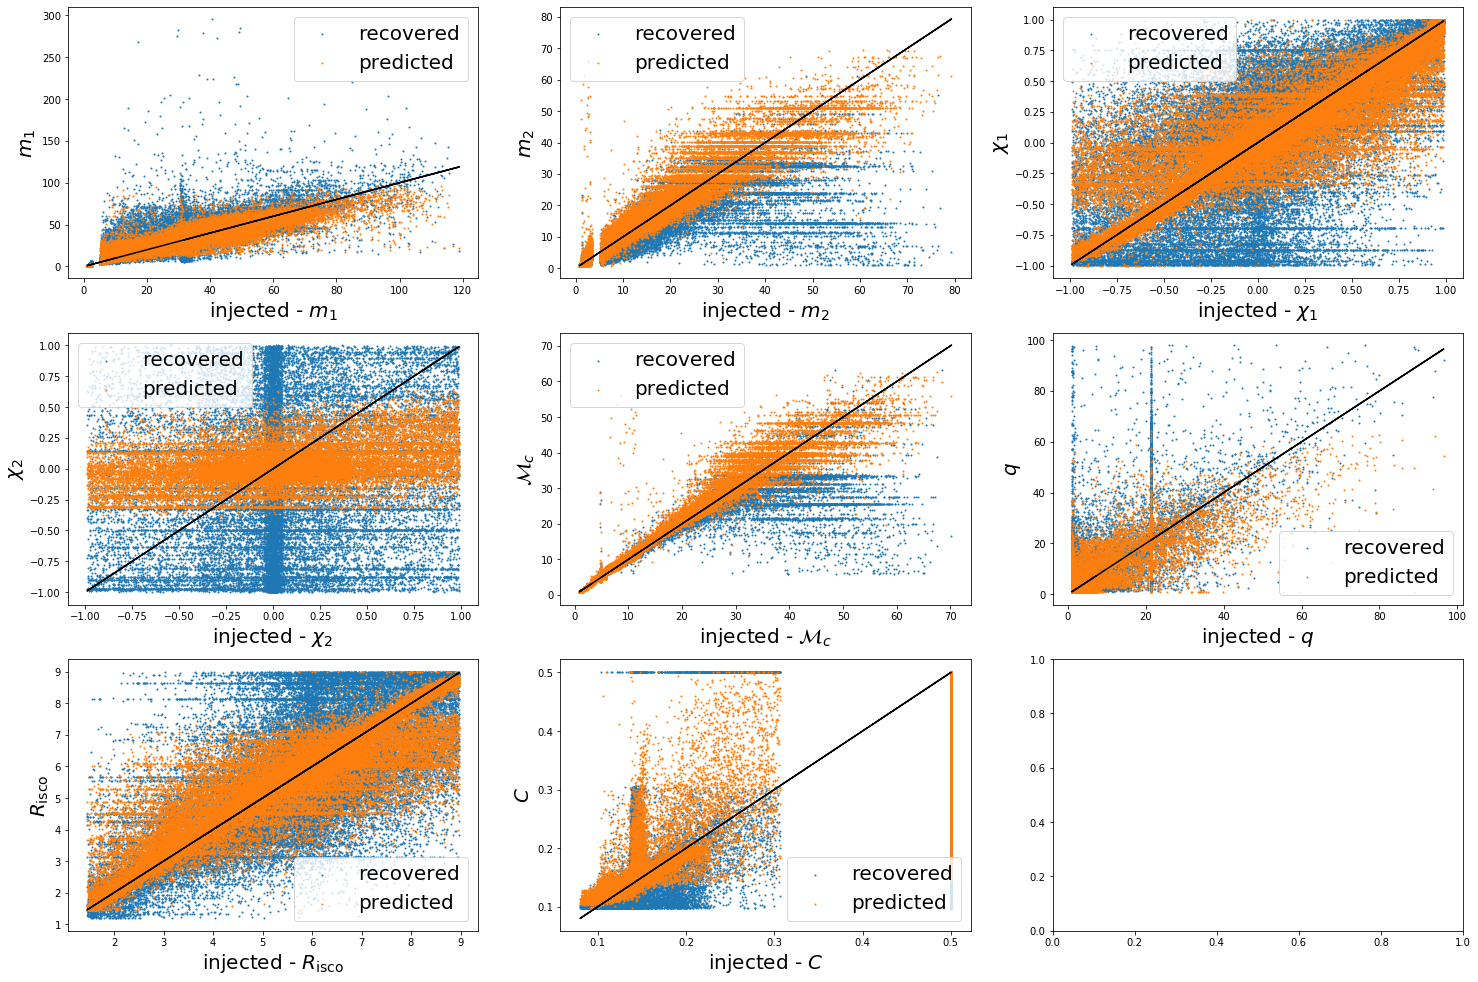

In [17]:
import sys
sys.path.insert(0, '/home/simone/repos/IPAM2021_ML/utils')
import fancyplots as fp
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, scaler_y=NN.scaler_y, scaler_x=NN.scaler_x)

In [18]:
predicted = NN.compute_prediction(NN.xtest, transform_output=True)
injected  = NN.ytest_notnorm
recovered = NN.xtest_notnorm

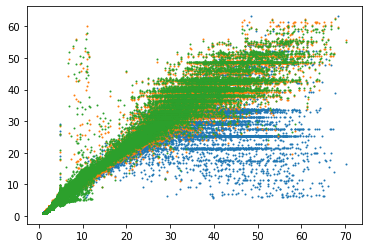

In [19]:
m1_pred = predicted[:,0]
m2_pred = predicted[:,1]
Mc_pred = predicted[:,4]

m1_inj  = injected[:,0]
m2_inj  = injected[:,1]
Mc_inj  = injected[:,4]
                    
m1_rec  = recovered[:,0]
m2_rec  = recovered[:,1]
Mc_rec  = recovered[:,4]

def compute_Mc(m1,m2):
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

Mc_comp = compute_Mc(m1_pred, m2_pred)

plt.figure
plt.scatter(Mc_inj, Mc_rec , s=1)
plt.scatter(Mc_inj, Mc_pred, s=1)
plt.scatter(Mc_inj, Mc_comp, s=1)
plt.show()